# USAD

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

torch.cuda.empty_cache()


import math
import time
from datetime import datetime
import pytz
import os
import json


from utils import *
from usad import *

from sklearn.decomposition import PCA

import wandb #For logging results in weights and bias
# wandb.login() 
# os.environ["WANDB_MODE"] = "offline"

# wandb.init(project="capstone-usad")



/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !nvidia-smi -L

device = get_default_device()

### Select dataset

In [3]:
# Dataset to be used
dataset='Swat'

if dataset=='Swat': #Full swat dataset
    traindata='/dataset/swat/SWaT_Dataset_Normal_v1.csv'
    testdata='/dataset/swat/SWaT_Dataset_Attack_v0.csv'
    time_col= " Timestamp"
    label_col="Normal/Attack"

elif dataset=='Swat(us)': # Swat dataset undersampled by 10 times
    traindata='/dataset/swat(mini)/train.csv'
    testdata='/dataset/swat(mini)/test.csv'
    time_col= "Unnamed: 0"
    label_col="attack"
    


## EDA - Data Pre-Processing

### Normal period

In [4]:

normal = pd.read_csv(traindata)#, nrows=1000)

normal.shape

(495000, 53)

In [5]:
normal.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:30:00 PM,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
1,22/12/2015 4:30:01 PM,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2,22/12/2015 4:30:02 PM,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
3,22/12/2015 4:30:03 PM,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
4,22/12/2015 4:30:04 PM,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


In [6]:
normal[label_col].value_counts()

Normal    495000
Name: Normal/Attack, dtype: int64

In [7]:
#Drop the anormalies from the train data
# Swat train data already do no contain abnormal data
if dataset!='Swat':
    normal= normal.loc[normal[label_col] == 0] 
normal.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:30:00 PM,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
1,22/12/2015 4:30:01 PM,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2,22/12/2015 4:30:02 PM,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
3,22/12/2015 4:30:03 PM,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
4,22/12/2015 4:30:04 PM,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


In [8]:
# normal.head()

In [9]:
normal[label_col].value_counts()

Normal    495000
Name: Normal/Attack, dtype: int64

In [10]:
#Drop the time and label column from the train data

normal = normal.drop([time_col , label_col] , axis = 1)
# normal = normal.drop([label_col] , axis = 1)
normal.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
1,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
2,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
3,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
4,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1


In [11]:
# print(type(normal.iloc[0,1]))
# normal.dtypes

In [12]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [13]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()

if dataset=='Swat':
    x = normal.values
    x_scaled = min_max_scaler.fit_transform(x)
#     normal = pd.DataFrame(x_scaled)

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

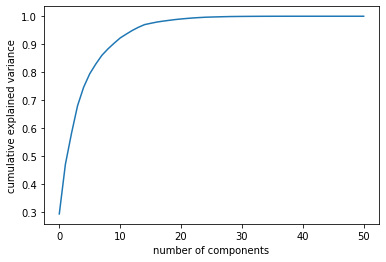

In [14]:
pca = PCA().fit(x_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first N components. For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

In [15]:
pca = PCA(n_components = 0.9) # 
X_pca = pca.fit_transform(x_scaled) # this will fit and reduce dimensions
print(pca.n_components_) # one can print and see how many components are selected. In this case it is 4 same as above we saw in step 5

10


In [16]:
pd.DataFrame(pca.components_, columns = normal.columns)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,-0.013937,-0.047245,-0.013989,-0.024872,-5.551115e-17,-0.038831,0.016289,0.029578,-0.024891,-0.018291,...,-0.282626,-0.286320,-0.0,-0.279140,-0.082766,-0.275378,0.001328,-0.0,0.001212,-0.0
1,-0.050104,0.231110,-0.057036,-0.348667,0.000000e+00,0.004226,0.117944,-0.040019,-0.347087,-0.345937,...,0.017746,0.016565,0.0,0.013736,-0.016771,0.013125,0.030433,0.0,0.028826,0.0
2,-0.027696,-0.007447,-0.027350,-0.014525,-3.989864e-17,-0.298181,0.123445,0.348865,-0.013925,-0.016112,...,0.077968,0.048705,-0.0,0.107326,0.192450,0.121488,-0.003558,-0.0,-0.003783,-0.0
3,0.355236,-0.284059,0.350302,0.129344,5.551115e-17,-0.042446,-0.062374,0.026146,0.134352,0.129220,...,-0.007339,-0.005129,-0.0,0.006107,0.041966,0.008492,0.268086,-0.0,0.273254,-0.0
4,-0.333837,0.177561,-0.329592,0.013280,5.551115e-17,0.022891,-0.036870,-0.046084,0.010077,0.011292,...,0.017063,0.016801,-0.0,0.005616,-0.002798,0.002828,0.408269,-0.0,0.445752,-0.0
5,-0.068945,0.046721,-0.070118,-0.003768,5.551115e-17,-0.335784,-0.280787,-0.397111,-0.004732,-0.002799,...,-0.007587,-0.005316,0.0,0.005213,0.223071,0.006240,-0.076680,0.0,-0.092358,0.0
6,-0.066250,-0.089600,-0.069519,0.057294,1.110223e-16,0.380887,-0.168144,-0.063405,0.059300,0.054596,...,0.037395,0.044604,-0.0,0.047371,0.125219,0.044109,-0.097144,-0.0,-0.138460,-0.0
7,0.239297,-0.095375,0.239836,-0.144778,-0.000000e+00,0.148400,-0.159659,-0.178643,-0.143764,-0.147359,...,-0.002387,0.002035,-0.0,0.019914,0.193792,0.021199,0.094511,-0.0,0.141437,-0.0
8,-0.209072,0.048540,-0.226522,0.151815,5.551115e-17,-0.049005,0.131840,0.095371,0.154804,0.152327,...,0.012247,0.017936,-0.0,0.006649,-0.143063,0.003681,0.018705,-0.0,-0.047083,-0.0
9,0.114219,-0.028663,0.120996,-0.026086,-5.551115e-17,-0.224419,0.575049,0.019420,-0.030723,-0.029206,...,-0.009687,0.028903,-0.0,-0.023781,-0.284201,-0.039100,-0.009920,-0.0,0.017066,-0.0


In [17]:
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = normal.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
print(most_important_names)

['FIT401', 'P101', 'AIT402', 'FIT101', 'P602', 'AIT503', 'P301', 'MV304', 'MV304', 'AIT202']


In [18]:
normal.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,0.0,124.3135,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0
1,0.0,124.3920,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0
2,0.0,124.4705,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0
3,0.0,124.6668,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0
4,0.0,124.5098,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0


In [19]:
normal2 = normal[normal.columns.intersection(most_important_names)]

In [20]:
normal2.head()

,FIT101,P101,AIT202,MV304,P301,AIT402,FIT401,AIT503,P602
0,0.0,1.0,8.313446,1.0,1.0,169.2387,0.0,260.7024,1.0
1,0.0,1.0,8.313446,1.0,1.0,169.2387,0.0,260.7024,1.0
2,0.0,1.0,8.313446,1.0,1.0,169.2387,0.0,260.7024,1.0
3,0.0,1.0,8.313446,1.0,1.0,169.2387,0.0,260.7024,1.0
4,0.0,1.0,8.313446,1.0,1.0,169.2387,0.0,260.7024,1.0


In [21]:
if dataset=='Swat':
    x = normal2.values
    x_scaled = min_max_scaler.fit_transform(x)
    normal = pd.DataFrame(x_scaled)

In [22]:
normal

,0,1,2,3,4,5,6,7,8
0,-1.633984,-1.728131,-0.828035,-0.126355,-0.060057,-0.158643,-18.104095,-1.185669,-0.089482
1,-1.633984,-1.728131,-0.828035,-0.126355,-0.060057,-0.158643,-18.104095,-1.185669,-0.089482
2,-1.633984,-1.728131,-0.828035,-0.126355,-0.060057,-0.158643,-18.104095,-1.185669,-0.089482
3,-1.633984,-1.728131,-0.828035,-0.126355,-0.060057,-0.158643,-18.104095,-1.185669,-0.089482
4,-1.633984,-1.728131,-0.828035,-0.126355,-0.060057,-0.158643,-18.104095,-1.185669,-0.089482
...,...,...,...,...,...,...,...,...,...
494995,0.538489,0.578660,0.091710,-0.126355,-0.060057,-1.176790,0.113652,-0.448892,-0.089482
494996,0.528309,0.578660,0.091710,-0.126355,-0.060057,-1.176790,0.113652,-0.448892,-0.089482
494997,0.515865,0.578660,0.091710,-0.126355,-0.060057,-1.176790,0.113652,-0.448892,-0.089482
494998,0.510209,0.578660,0.091710,-0.126355,-0.060057,-1.176790,0.093240,-0.448892,-0.089482


### Attack

In [23]:
#Read data
# attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=",")#, nrows=1000)
attack = pd.read_csv(testdata,sep=",")#, nrows=1000)

# Create test labels

if dataset=='Swat':
    # For swat dataset
#     labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
    labels = [ float(label!= 'Normal' ) for label  in attack[label_col].values]

#For others SMAP, MSL, CC
else:
    labels = [ float(label!= 0 ) for label  in attack[label_col].values]



In [24]:
attack[label_col].value_counts()

Normal     395298
Attack      54584
A ttack        37
Name: Normal/Attack, dtype: int64

In [25]:
attack[label_col].value_counts()[1]

54584

In [26]:
attack = attack.drop([time_col , label_col] , axis = 1)
# attack = attack.drop([label_col] , axis = 1)


attack.shape

(449919, 51)

In [27]:
labels.count(1)

54621

In [28]:
attack.shape[0]

449919

### Test data anomaly percentage 

In [29]:
anormaly_percentage=labels.count(1)/attack.shape[0]*100
anormaly_percentage

12.140185233342002

In [30]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

In [31]:
attack = attack[attack.columns.intersection(most_important_names)]

In [32]:
attack

,FIT101,P101,AIT202,MV304,P301,AIT402,FIT401,AIT503,P602
0,2.427057,2.0,8.396437,1.0,1.0,156.0882,1.713517,264.5475,1.0
1,2.446274,2.0,8.396437,1.0,1.0,156.0882,1.715952,264.5475,1.0
2,2.489191,2.0,8.394514,1.0,1.0,156.0882,1.715952,264.5475,1.0
3,2.534350,2.0,8.394514,1.0,1.0,156.0882,1.714670,264.5475,1.0
4,2.569260,2.0,8.394514,1.0,1.0,156.0882,1.714670,264.5475,1.0
...,...,...,...,...,...,...,...,...,...
449914,2.559972,2.0,8.638683,1.0,1.0,145.6037,1.705315,257.1136,1.0
449915,2.549082,2.0,8.638683,1.0,1.0,145.6037,1.705315,257.1136,1.0
449916,2.531467,2.0,8.638683,1.0,1.0,145.5524,1.706212,257.1136,1.0
449917,2.521218,2.0,8.638683,1.0,1.0,145.5524,1.706212,257.1136,1.0


#### Normalization

In [33]:
from sklearn import preprocessing

if dataset=='Swat':
    x = attack.values 
    x_scaled = min_max_scaler.transform(x)
    attack = pd.DataFrame(x_scaled)

In [34]:
attack.head(2)

,0,1,2,3,4,5,6,7,8
0,0.509078,0.57866,0.09171,-0.126355,-0.060057,-1.17679,0.09324,-0.448892,-0.089482
1,0.526046,0.57866,0.09171,-0.126355,-0.060057,-1.17679,0.11910,-0.448892,-0.089482


### Windows

In [35]:
window_size=1     #5 ,10 ,30,60

In [36]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494999, 1, 9)

In [37]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449918, 1, 9)

## Training

In [38]:
import torch.utils.data as data_utils

BATCH_SIZE =  1000 #1000
N_EPOCHS = 100
hidden_size = 5 # 10,30,50 

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size= windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [39]:
w_size, z_size

(9, 5)

In [40]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.6505, val_loss2: 0.6864
Epoch [1], val_loss1: 0.6533, val_loss2: -0.0066
Epoch [2], val_loss1: 0.6508, val_loss2: -0.2312
Epoch [3], val_loss1: 0.6522, val_loss2: -0.3423
Epoch [4], val_loss1: 0.6540, val_loss2: -0.4078
Epoch [5], val_loss1: 0.6556, val_loss2: -0.4511
Epoch [6], val_loss1: 0.6569, val_loss2: -0.4821
Epoch [7], val_loss1: 0.6582, val_loss2: -0.5055
Epoch [8], val_loss1: 0.6599, val_loss2: -0.5244
Epoch [9], val_loss1: 0.6607, val_loss2: -0.5390
Epoch [10], val_loss1: 0.6615, val_loss2: -0.5510
Epoch [11], val_loss1: 0.6618, val_loss2: -0.5608
Epoch [12], val_loss1: 0.6625, val_loss2: -0.5694
Epoch [13], val_loss1: 0.6633, val_loss2: -0.5770
Epoch [14], val_loss1: 0.6640, val_loss2: -0.5837
Epoch [15], val_loss1: 0.6651, val_loss2: -0.5899
Epoch [16], val_loss1: 0.6660, val_loss2: -0.5953
Epoch [17], val_loss1: 0.6669, val_loss2: -0.6002
Epoch [18], val_loss1: 0.6679, val_loss2: -0.6048
Epoch [19], val_loss1: 0.6687, val_loss2: -0.6088
Epoch [20],

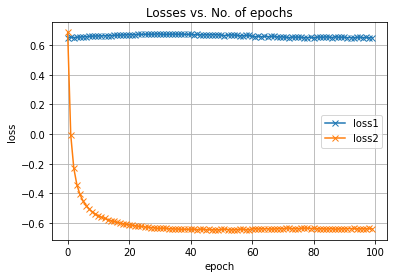

In [41]:
plot_history(history)

In [42]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

In [43]:
# model

## Testing

In [44]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [45]:
#                       alpha, beta 
# results=testing(model,test_loader,0.5,0.5)

with torch.no_grad(): results=testing(model,test_loader,0.5,0.5)

In [46]:
len(results)

450

In [47]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [48]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [49]:
print(len(windows_labels))

449918


In [50]:
labels.count(0)


395298

In [51]:
num_windows=len(y_test)
num_anormal_windows=y_test.count(1)
win_anormal_percentage=num_anormal_windows/num_windows*100

print('Number of windows :'+ str(len(y_test)))
print('Number of windows (abnormal) :'+ str(y_test.count(1)))
print('Number of windows (normal) :'+ str(y_test.count(0)))
print('Abnormal windows (%) :'+ str(round(win_anormal_percentage,3)))


Number of windows :449918
Number of windows (abnormal) :54621
Number of windows (normal) :395297
Abnormal windows (%) :12.14


In [52]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [53]:
len(y_test), len(y_pred)

(449918, 449918)

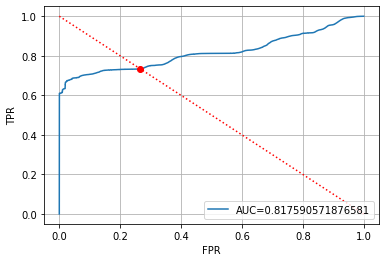

In [54]:
threshold=ROC(y_test,y_pred)



In [55]:
print('Threshold : ', threshold)

Threshold :  [1.6699549]


In [72]:
threshold= [18]
# threshold= [0.305] #Optimal threshold for swat(us)
# threshold= [15] #Threshold for Swat for good F1 

In [73]:
y_pred_ = np.zeros(y_pred.shape[0])

In [74]:
y_pred_[y_pred >= threshold] = 1

In [75]:
y_pred_

array([0., 0., 0., ..., 0., 0., 0.])

In [76]:
np.array(y_test)

array([0., 0., 0., ..., 0., 0., 0.])

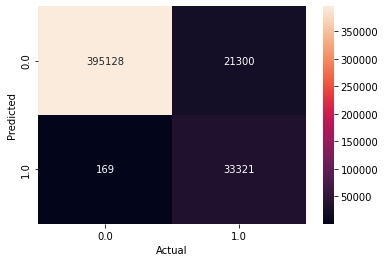

In [77]:
confusion_matrix(np.array(y_test), y_pred_)

In [78]:
import sklearn

In [79]:
print(sklearn.metrics.classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    395297
         1.0       0.99      0.61      0.76     54621

    accuracy                           0.95    449918
   macro avg       0.97      0.80      0.86    449918
weighted avg       0.95      0.95      0.95    449918



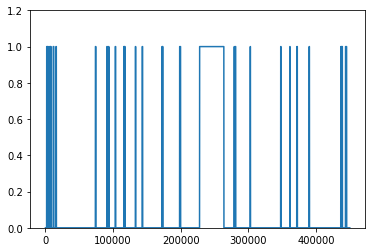

In [80]:
plt.plot(y_test)


plt.ylim([0,1.2])
plt.savefig("y_test.png") 
plt.show()


In [81]:
# x=list(range(len(y_test)))
x=list(range(len(labels)))


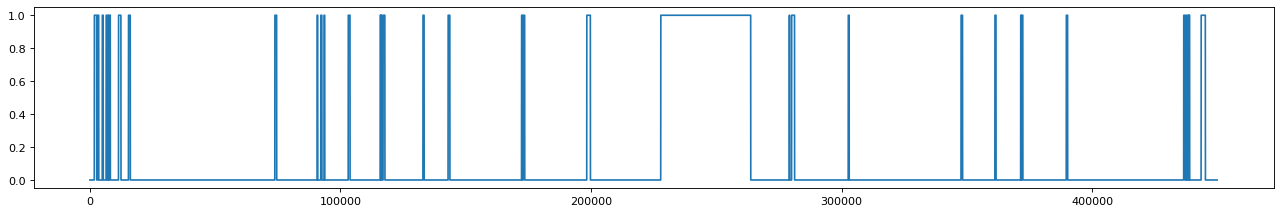

In [82]:
x=list(range(len(labels)))
plt.figure(figsize=(20, 3), dpi=80)
# plt.plot(x, y_test)
plt.plot(x, labels)

plt.show()

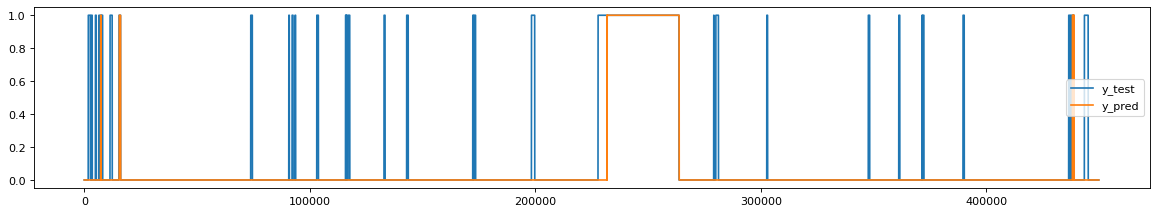

In [83]:
x=list(range(len(y_test)))

plt.figure(figsize=(18, 3), dpi=80)

plt.plot(x, y_test, label = "y_test")
plt.plot(x, y_pred_, label = "y_pred")

plt.legend()
plt.show()




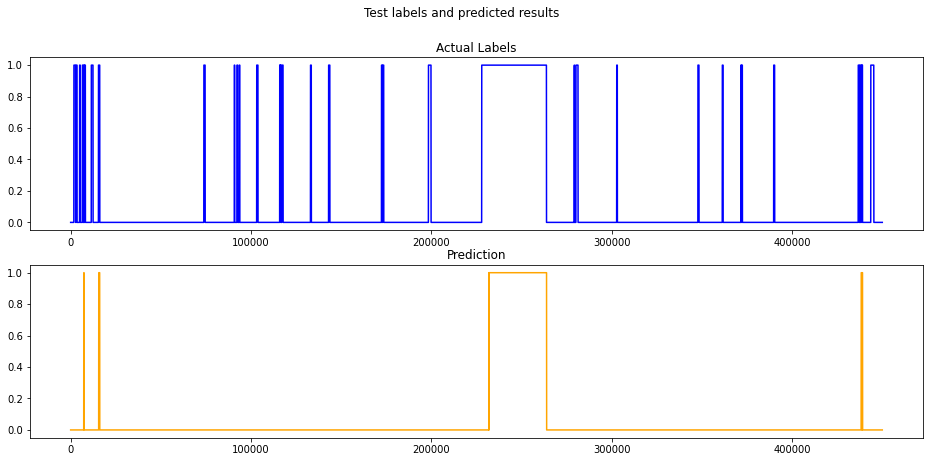

In [84]:
x=list(range(len(y_test)))

fig, (ax1, ax2) = plt.subplots(2, figsize=(16,7))

fig.suptitle('Test labels and predicted results')
ax1.plot(x, y_test, 'b')
ax2.plot(x, y_pred_, color='orange')
ax1.set_title('Actual Labels')
ax2.set_title('Prediction')

fig.savefig("fig1.png") 

### Plot the anomaly score

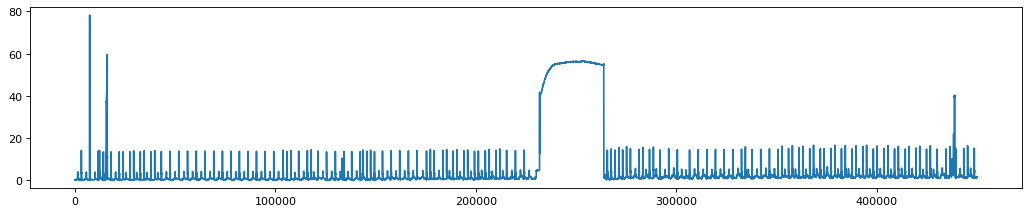

<Figure size 432x288 with 0 Axes>

In [85]:
plt.figure(figsize=(16, 3), dpi=80)
plt.plot(x, y_pred)
plt.show()
plt.savefig("2.png") 

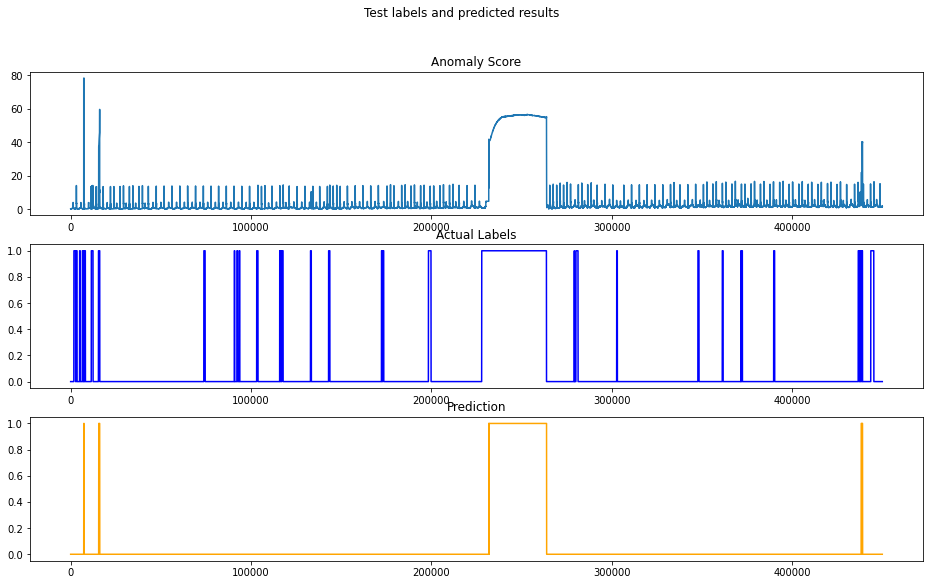

In [94]:
x=list(range(len(y_test)))

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,9))

fig.suptitle('Test labels and predicted results')
ax1.plot(x, y_pred)
ax2.plot(x, y_test, 'b')
ax3.plot(x, y_pred_, color='orange')

ax1.set_title('Anomaly Score')
ax2.set_title('Actual Labels')
ax3.set_title('Prediction')


fig.savefig("fig1.png") 

In [87]:
# report = sklearn.metrics.classification_report(y_test, y_pred_)

In [88]:
report = sklearn.metrics.classification_report(y_test, y_pred_, output_dict=True)


In [89]:
# accuracy = report[1]
# print(report)

In [90]:
precision =  report['1.0']['precision'] 
recall = report['1.0']['recall']    
f1 = report['1.0']['f1-score']

In [91]:
# wandb.init(project=dataset, config={"epochs": N_EPOCHS, "batch_size": BATCH_SIZE,\
#                                     "hidden_size": hidden_size, "window_size": window_size,\
#                                     "dataset": dataset, "anomaly": str(round(anormaly_percentage,3))+'%'})



wandb.init(project=dataset, config={"epochs": N_EPOCHS,\
                                    "batch_size": BATCH_SIZE,\
                                    "hidden_size": hidden_size,\
                                    "window_size": window_size,\
                                    "dataset": dataset,\
                                    "anomaly": str(round(anormaly_percentage,3))+'%',\
                                    "win anomaly": str(round(win_anormal_percentage,3))+'%',\

                                    })

# wandb.init(project='CC_SS', config={"epochs": N_EPOCHS,\
#                                     "batch_size": BATCH_SIZE,\
#                                     "hidden_size": hidden_size,\
#                                     "window_size": window_size,\
#                                     "dataset": dataset,\
#                                     "anomaly": str(round(anormaly_percentage,3))+'%',\
#                                     "win anomaly": str(round(win_anormal_percentage,3))+'%',\
#                                     })



# remarks='batch size: '+ str(BATCH_SIZE) + ', epoch: '+ str(N_EPOCHS) + ', win_size: '+ str(window_size) + \
# ', hid size: '+ str(hidden_size)




#api key ad12641c47042f4b9e35d82ab5a7afab9dfa7629

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [92]:
wandb.log({
    "Threshold" : threshold,
    "Precision" : precision,
    "Recall" : recall,
    "F1" : f1,
    "Training Loss": wandb.Image("training_loss.png"),
    "Confusion Matrix": wandb.Image("CF_heatmap.png"),
    "Y_test Plot": wandb.Image("y_test.png"),
})

# wandb.log({"Training Loss": wandb.Image("training_loss.png")})
# wandb.log({"Confusion Matrix": wandb.Image("CF_heatmap.png")})


In [63]:
# x = {'datetime': datetime.now().strftime("%d-%b-%Y, %H:%M:%S"), 'F1_score': round(f1,2), 'Precision': round(precision,2), 'Recall': round(recall,2), 'Remarks': remarks }


In [93]:
#Path to save the performance metric result


path=os.path.join(os.getcwd(),'result_final')

# file_path = os.sep.join([path, 'result_'+dataset+'.json'])
file_path = os.sep.join([path, 'result_'+'swat'+'.json'])

# print(file_path)




In [65]:
# y = {'datetime': datetime.now().strftime("%d-%b-%Y, %H:%M:%S"), 'F1_score': round(f1,2), 'Precision': round(precision,2), 'Recall': round(recall,2), 'Remarks': remarks }



y = {'datetime': datetime.now().strftime("%d-%b-%Y, %H:%M:%S"),
     'F1_score': round(f1,2),
     'Precision': round(precision,2),
     'Recall': round(recall,2),
     'Epoch': N_EPOCHS,
     'Batch Size': BATCH_SIZE ,
     'Win Size': window_size,
     'Hidden_size': hidden_size ,
     'Threshold': str(threshold[0]),
     'Win_anomaly(%)': str(round(win_anormal_percentage,3)),

    }




if os.path.isfile(file_path): #if an existing file exist in file_path 
    with open(file_path, 'r+') as f:
        file_data = json.load(f)
        
        if dataset in file_data.keys():
            file_data[dataset].append(y)
            f.seek(0)
        else:
            file_data[dataset] = [y]
            f.seek(0)
            
        json.dump(file_data, f, indent=10)
else:
    with open(file_path, 'w') as f:
        file_data = {dataset: [y]}
        json.dump(file_data, f, indent=10)    
          

In [66]:
# file_path = os.sep.join([os.getcwd(), 'result.json'])
file_path

'/workspace/result_final/result_swat.json'

In [67]:
with open(file_path, 'r') as f:
    data = json.load(f)

temp = []
for k in data.keys():
    df = pd.json_normalize(data[k])
    df.insert(1, 'Dataset', k)
    temp.append(df)

df1 = pd.concat(temp, axis=0).reset_index(drop=True)
df1

,datetime,Dataset,F1_score,Precision,Recall,Epoch,Batch Size,Win Size,Hidden_size,Threshold,Win_anomaly(%)
0,"06-Nov-2022, 21:51:47",Swat,0.74,0.89,0.64,60,1000,2,1,10,12.148
1,"06-Nov-2022, 22:06:06",Swat,0.74,0.89,0.64,60,1000,2,5,10,12.148
2,"06-Nov-2022, 22:17:27",Swat,0.75,0.91,0.64,60,1000,2,10,10,12.148
3,"06-Nov-2022, 22:29:09",Swat,0.74,0.89,0.64,60,1000,2,20,10,12.148
4,"06-Nov-2022, 07:39:50",Swat,0.75,0.90,0.63,100,1000,20,30,10,12.289
5,"06-Nov-2022, 08:00:28",Swat,0.75,0.90,0.63,100,1000,20,20,10,12.289
6,"06-Nov-2022, 08:19:16",Swat,0.75,0.91,0.63,100,1000,20,10,10,12.289
7,"06-Nov-2022, 11:18:28",Swat,0.74,0.90,0.63,100,1000,20,5,10,12.289
8,"04-Nov-2022, 03:26:01",Swat,0.74,0.90,0.63,60,1000,20,20,10,12.289
9,"04-Nov-2022, 03:39:29",Swat,0.75,0.90,0.64,60,1000,10,20,10,12.21


In [68]:
pd.options.display.max_colwidth=100
df1

,datetime,Dataset,F1_score,Precision,Recall,Epoch,Batch Size,Win Size,Hidden_size,Threshold,Win_anomaly(%)
0,"06-Nov-2022, 21:51:47",Swat,0.74,0.89,0.64,60,1000,2,1,10,12.148
1,"06-Nov-2022, 22:06:06",Swat,0.74,0.89,0.64,60,1000,2,5,10,12.148
2,"06-Nov-2022, 22:17:27",Swat,0.75,0.91,0.64,60,1000,2,10,10,12.148
3,"06-Nov-2022, 22:29:09",Swat,0.74,0.89,0.64,60,1000,2,20,10,12.148
4,"06-Nov-2022, 07:39:50",Swat,0.75,0.90,0.63,100,1000,20,30,10,12.289
5,"06-Nov-2022, 08:00:28",Swat,0.75,0.90,0.63,100,1000,20,20,10,12.289
6,"06-Nov-2022, 08:19:16",Swat,0.75,0.91,0.63,100,1000,20,10,10,12.289
7,"06-Nov-2022, 11:18:28",Swat,0.74,0.90,0.63,100,1000,20,5,10,12.289
8,"04-Nov-2022, 03:26:01",Swat,0.74,0.90,0.63,60,1000,20,20,10,12.289
9,"04-Nov-2022, 03:39:29",Swat,0.75,0.90,0.64,60,1000,10,20,10,12.21


In [69]:
print(threshold)

[0.305]


In [70]:
import sklearn
threshold = [0.3]
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1
print(sklearn.metrics.classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     39425
         1.0       0.96      0.59      0.73      5563

    accuracy                           0.95     44988
   macro avg       0.95      0.79      0.85     44988
weighted avg       0.95      0.95      0.94     44988



In [71]:
threshold = [0.305]
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1
print(sklearn.metrics.classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     39425
         1.0       0.98      0.59      0.73      5563

    accuracy                           0.95     44988
   macro avg       0.96      0.79      0.85     44988
weighted avg       0.95      0.95      0.94     44988

